Pytorch를 사용한 LSTM 텍스트 분류<br>
https://ichi.pro/ko/pytorchleul-sayonghan-lstm-tegseuteu-bunlyu-48844070948800

In [2]:
!pip install torchtext

     |████████████████████████████████| 1.7 MB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 147.1 MB 108 kB/s eta 0:00:011    |████████████▎                   | 56.5 MB 10.6 MB/s eta 0:00:09
ERROR: torchvision 0.8.2 has requirement torch==1.7.1, but you'll have torch 1.10.1 which is incompatible.
ERROR: lightautoml 0.3.0 has requirement torch<1.9, but you'll have torch 1.10.1 which is incompatible.
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

from torchtext.legacy.data import Field, TabularDataset, BucketIterator

# Model
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

#training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
import seaborn as sns

ImportError: dlopen(/opt/anaconda3/lib/python3.7/site-packages/torchtext/_torchtext.so, 2): Symbol not found: __ZNK3c104Type14isSubtypeOfExtERKNSt3__110shared_ptrIS0_EEPNS1_13basic_ostreamIcNS1_11char_traitsIcEEEE
  Referenced from: /opt/anaconda3/lib/python3.7/site-packages/torchtext/_torchtext.so
  Expected in: /opt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.dylib
 in /opt/anaconda3/lib/python3.7/site-packages/torchtext/_torchtext.so

In [ ]:
data = pd.read_csv('./unethical_01.csv')

In [ ]:
data

In [19]:
#train,test = train_test_split(data,train_size = 0.9)

In [20]:
#train

In [21]:
#train.describe()

In [22]:
#train = train.rename(columns={'범죄':'crime'})
#test = test.rename(columns={'범죄':'crime'})

In [23]:
#train.to_csv('./lstm_train.csv')

In [24]:
#test.to_csv('./lstm_test.csv')

In [25]:
train = pd.read_csv('./train_ml2.csv')
test = pd.read_csv('./test_ml2.csv')

In [26]:
train = train[['sentence','범죄','혐오','선정','비도덕 아님','폭력','비난','욕설','차별']]
test = test[['sentence','범죄','혐오','선정','비도덕 아님','폭력','비난','욕설','차별']]

In [27]:
train,valid = train_test_split(data,train_size = 0.9)

In [28]:
train[train['sentence'].isna()]

,sentence,범죄,혐오,선정,비도덕 아님,폭력,비난,욕설,차별


In [29]:
train.to_csv('./train_multilabel.csv')
valid.to_csv('./valid_ml.csv')
test.to_csv('./test_multilabel.csv')

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
# Fields
id_field = Field(sequential = False,
                use_vocab = False) # 실제 사용은 하지 않을 예정
text_field = Field(sequential=True,
             use_vocab=True,
             tokenize=str.split, lower = True, include_lengths = True, batch_first = True,dtype = torch.long)
label_field = Field(sequential=False, use_vocab = False,dtype=torch.float)

#fields = [('id',id_field),('sentence',text_field),('crime',label_field)]
fields = [('id',id_field),('sentence',text_field),('crime',label_field),('혐오',label_field),('선정',label_field),('비도덕 아님',label_field),('폭력',label_field),('비난',label_field),('욕설',label_field),('차별',label_field)]


In [32]:
# Tabular Dataset
train,valid,test = TabularDataset.splits(path = './', train = 'train_multilabel.csv',validation = 'valid_ml.csv',test = 'test_multilabel.csv',format = 'CSV',fields = fields, skip_header=True)


In [33]:
train_iter = BucketIterator(train, batch_size = 64, device = device, sort_key=lambda x: len(x.sentence),shuffle=True, sort_within_batch = True)
valid_iter = BucketIterator(valid, batch_size = 64, device = device, sort_key=lambda x: len(x.sentence),shuffle=True, sort_within_batch = True)

test_iter = BucketIterator(test, batch_size = 64, device = device, sort_key=lambda x: len(x.sentence),shuffle=True, sort_within_batch = True)


In [34]:
text_field.build_vocab(train)

In [35]:
label_field

# Model

In [36]:
class LSTM(nn.Module):
    def __init__(self,dimension=128):
        super(LSTM,self).__init__()
        self.embedding = nn.Embedding(len(text_field.vocab),32)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size = 32,hidden_size = dimension,num_layers=1,batch_first = True,bidirectional = True)
        
        self.drop = nn.Dropout(p=0.5)
        
        self.fc = nn.Linear(2*dimension,1)
        
    def forward(self,text,text_len):
        text_emb = self.embedding(text)
        packed_input = pack_padded_sequence(text_emb, text_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension] # 정방향 lstm의 마지막 hidden state
        out_reverse = output[:, 0, self.dimension:] # 역방향 lstm의 첫번째 hidden state
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out
        

In [37]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [38]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = '.',
          best_valid_loss = float("Inf"),
          category_num=0
          ):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    ctg = ['crime', 'hate', 'sexual', 'none','violent','blame','curse','discrimination']
    
    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (i,(text, text_len),crime, hate, sexual, none,violent,blame,curse,discrimination),_ in train_loader:
        #for (i,(text,text_len),labels),_ in train_loader:
                categories = [crime, hate, sexual, none,violent,blame,curse,discrimination]
                labels = categories[category_num].to(device)
                labels = labels.to(device)
                output = model(text, text_len)

                loss = criterion(output, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # update running values
                running_loss += loss.item()
                global_step += 1

                # evaluation step
                if global_step % eval_every == 0:
                    model.eval()
                    with torch.no_grad():                    
                      # validation loop

                        for (i,(text, text_len),crime, hate, sexual, none,violent,blame,curse,discrimination),_ in valid_loader:
                        #for (i,(text,text_len),labels),_ in train_loader:
                            v_cat = [crime, hate, sexual, none,violent,blame,curse,discrimination]
                            labels = v_cat[category_num].to(device)
                            #labels = labels.to(device)
                            output = model(text, text_len)
                            loss = criterion(output, labels)
                            valid_running_loss += loss.item()

                    # evaluation
                    average_train_loss = running_loss / eval_every
                    average_valid_loss = valid_running_loss / len(valid_loader)
                    train_loss_list.append(average_train_loss)
                    valid_loss_list.append(average_valid_loss)
                    global_steps_list.append(global_step)

                    # resetting running values
                    running_loss = 0.0                
                    valid_running_loss = 0.0
                    model.train()

                    # print progress
                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                          .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                                  average_train_loss, average_valid_loss))

                    # checkpoint
                    if best_valid_loss > average_valid_loss:
                        best_valid_loss = average_valid_loss
                        save_checkpoint(file_path +'/'+str(ctg[category_num])+ '_model.pt', model, optimizer, best_valid_loss)
                        save_metrics(file_path +'/'+str(ctg[category_num]) + '_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

    save_metrics(file_path +'/'+str(ctg[category_num]) + '_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for i in range(8):
    train(model=model, optimizer=optimizer, num_epochs=10,category_num=i)


Epoch [1/10], Step [70/1410], Train Loss: 0.2780, Valid Loss: 0.1653
Model saved to ==> ./crime_model.pt
Model saved to ==> ./crime_metrics.pt
Epoch [1/10], Step [140/1410], Train Loss: 0.1444, Valid Loss: 0.1528
Model saved to ==> ./crime_model.pt
Model saved to ==> ./crime_metrics.pt
Epoch [2/10], Step [210/1410], Train Loss: 0.1343, Valid Loss: 0.1556
Epoch [2/10], Step [280/1410], Train Loss: 0.1234, Valid Loss: 0.1565
Epoch [3/10], Step [350/1410], Train Loss: 0.1289, Valid Loss: 0.1617
Epoch [3/10], Step [420/1410], Train Loss: 0.1129, Valid Loss: 0.1632
Epoch [4/10], Step [490/1410], Train Loss: 0.1213, Valid Loss: 0.1727
Epoch [4/10], Step [560/1410], Train Loss: 0.1031, Valid Loss: 0.1808
Epoch [5/10], Step [630/1410], Train Loss: 0.1059, Valid Loss: 0.1885
Epoch [5/10], Step [700/1410], Train Loss: 0.0834, Valid Loss: 0.1980
Epoch [6/10], Step [770/1410], Train Loss: 0.0769, Valid Loss: 0.2438
Epoch [6/10], Step [840/1410], Train Loss: 0.0789, Valid Loss: 0.2147
Epoch [7/10],

In [39]:
text_field.vocab['부산출신']

14137

Model loaded from <== ./crime_metrics.pt


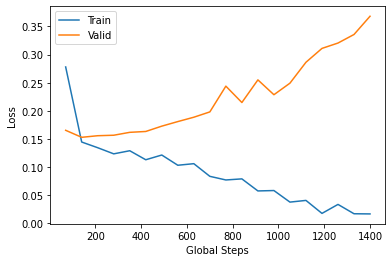

Model loaded from <== ./hate_metrics.pt


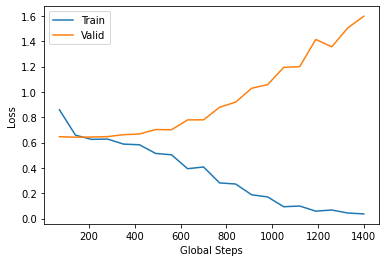

Model loaded from <== ./sexual_metrics.pt


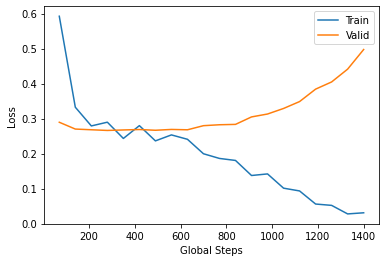

Model loaded from <== ./none_metrics.pt


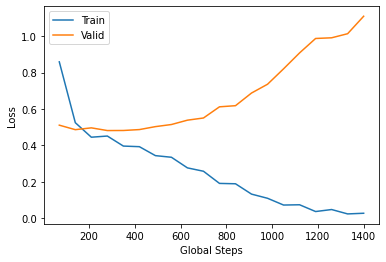

Model loaded from <== ./violent_metrics.pt


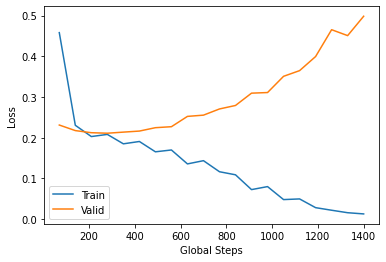

Model loaded from <== ./blame_metrics.pt


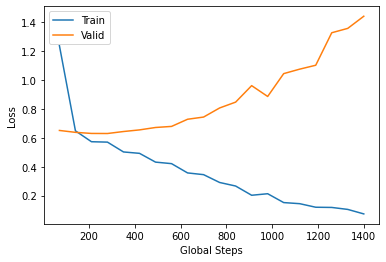

Model loaded from <== ./curse_metrics.pt


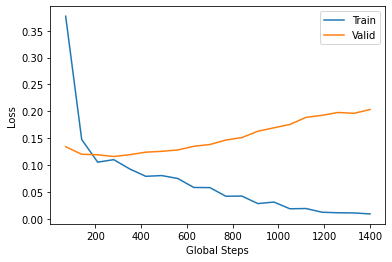

Model loaded from <== ./discrimination_metrics.pt


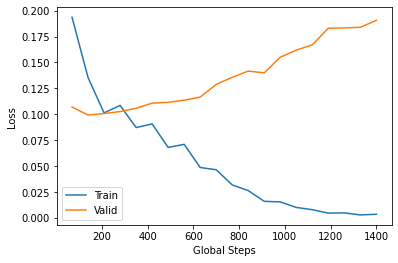

In [40]:
ctg = ['crime', 'hate', 'sexual', 'none','violent','blame','curse','discrimination']    
for i in range(8):
    train_loss_list, valid_loss_list, global_steps_list = load_metrics('./'+str(ctg[i])+'_' + 'metrics.pt')
    plt.plot(global_steps_list, train_loss_list, label='Train')
    plt.plot(global_steps_list, valid_loss_list, label='Valid')
    plt.xlabel('Global Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 

In [41]:
pd.DataFrame([0]*1038).to_csv('./result.csv',index=False)

Model loaded from <== ./crime_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        10
           0     0.9904    1.0000    0.9952      1028

    accuracy                         0.9904      1038
   macro avg     0.4952    0.5000    0.4976      1038
weighted avg     0.9808    0.9904    0.9856      1038



/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


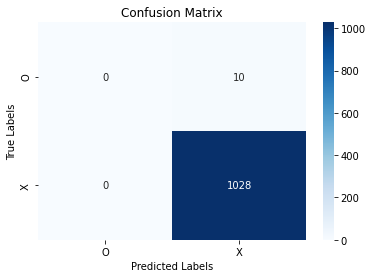

Model loaded from <== ./hate_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.1111    0.0079    0.0148       126
           0     0.8785    0.9912    0.9315       912

    accuracy                         0.8719      1038
   macro avg     0.4948    0.4996    0.4731      1038
weighted avg     0.7854    0.8719    0.8202      1038



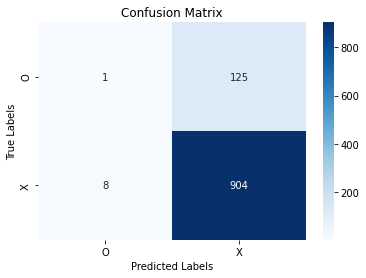

Model loaded from <== ./sexual_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        49
           0     0.9528    1.0000    0.9758       989

    accuracy                         0.9528      1038
   macro avg     0.4764    0.5000    0.4879      1038
weighted avg     0.9078    0.9528    0.9298      1038



/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


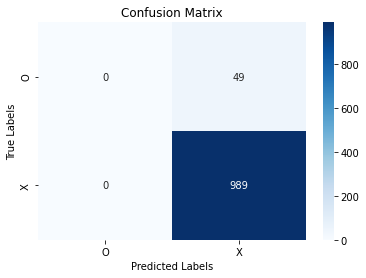

Model loaded from <== ./none_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8690    0.1086    0.1931       672
           0     0.3721    0.9699    0.5379       366

    accuracy                         0.4123      1038
   macro avg     0.6206    0.5393    0.3655      1038
weighted avg     0.6938    0.4123    0.3147      1038



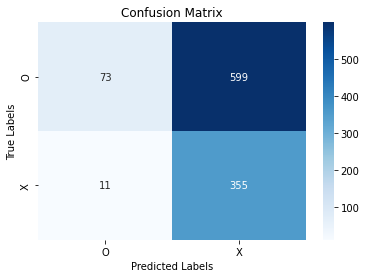

Model loaded from <== ./violent_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        40
           0     0.9615    1.0000    0.9804       998

    accuracy                         0.9615      1038
   macro avg     0.4807    0.5000    0.4902      1038
weighted avg     0.9244    0.9615    0.9426      1038



/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


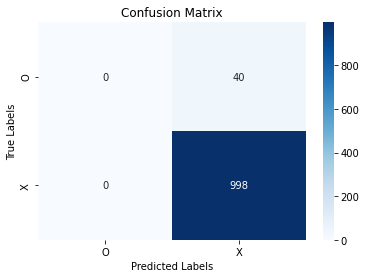

Model loaded from <== ./blame_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.3686    0.8502    0.5143       307
           0     0.8606    0.3885    0.5353       731

    accuracy                         0.5250      1038
   macro avg     0.6146    0.6193    0.5248      1038
weighted avg     0.7151    0.5250    0.5291      1038



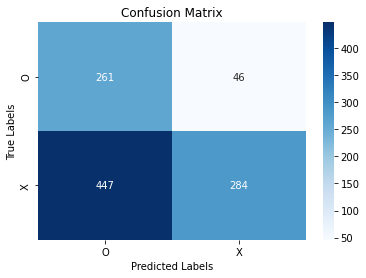

Model loaded from <== ./curse_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        30
           0     0.9711    1.0000    0.9853      1008

    accuracy                         0.9711      1038
   macro avg     0.4855    0.5000    0.4927      1038
weighted avg     0.9430    0.9711    0.9569      1038



/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


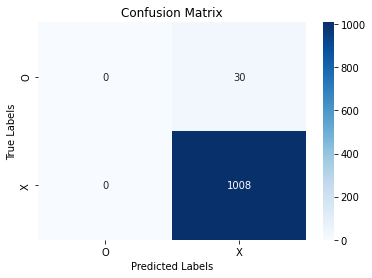

Model loaded from <== ./discrimination_model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         8
           0     0.9923    1.0000    0.9961      1030

    accuracy                         0.9923      1038
   macro avg     0.4961    0.5000    0.4981      1038
weighted avg     0.9846    0.9923    0.9885      1038



/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


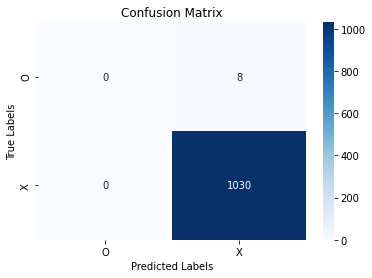

In [42]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5,category_num=0):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (i,(text, text_len),crime, hate, sexual, none,violent,blame,curse,discrimination),_ in test_loader:
        #for (i,(text, text_len),labels),_ in test_loader:           
            categories = [crime, hate, sexual, none,violent,blame,curse,discrimination]
            labels = categories[category_num].to(device)
            #labels = labels.to(device)
            output = model(text, text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    result = pd.read_csv('./result.csv')
    result[ctg[category_num]] = pd.DataFrame(y_pred)
    result.to_csv('./result.csv',index=False)
    # with open('result.csv', 'a') as f:
    #     pd.DataFrame(y_pred).to_csv(f,header=False)
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['O', 'X'])
    ax.yaxis.set_ticklabels(['O', 'X'])
    
ctg = ['crime', 'hate', 'sexual', 'none','violent','blame','curse','discrimination']    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

for i in range(8):
    load_checkpoint('.' +'/'+str(ctg[i]) + '_model.pt', best_model, optimizer)
    evaluate(best_model, test_iter,category_num=i)
    plt.show()

In [43]:
result = pd.read_csv('./result.csv')

In [44]:
result.columns

Index(['0', 'crime', 'hate', 'sexual', 'none', 'violent', 'blame', 'curse',
       'discrimination'],
      dtype='object')

In [45]:
result = result[['crime', 'hate', 'sexual', 'none', 'violent', 'blame', 'curse',
       'discrimination']]

In [46]:
result = np.array(result)

In [59]:
y_true = pd.read_csv('./test_ml2.csv')

In [60]:
y_true = y_true[['범죄', '혐오', '선정', '비도덕 아님', '폭력', '비난',
       '욕설', '차별']]

In [61]:
y_true = np.array(y_true)

In [62]:
y_true

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [63]:
cnt=0
for i in range(len(y_true)):
    if False not in (y_true[i]==result[i]):
        cnt+=1
acc = cnt/len(y_true)
acc

0.08477842003853564

In [64]:
f1_score(y_true, result, average='micro')

0.26138032305433184